In [2]:
#Libariries for Data Analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

#Libraries for ML
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

#To make the cells look cleaner
import warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
df = pd.read_csv('Cleaned Training.csv', index_col = 'match_id')
df2 = pd.read_csv('Cleaned Testing.csv', index_col = 'match_id')

In [4]:
df.head()

,r1_hero,r1_items,r2_hero,r2_items,r3_hero,r3_items,r4_hero,r4_items,r5_hero,r5_items,...,dire_first_ward_time,radiant_win,Radiant_Total_xp,Dire_Total_xp,Radiant_Total_gold,Dire_Total_gold,Radiant_Total_lh,Dire_Total_lh,Radiant_Total_kills,Dire_Total_kills
match_id,,,,,,,,,,,,,,,,,,,,,
1,44,7,97,6,29,9,85,8,40,7,...,0.0,1,5497,6419,4615,4348,46,52,0,0
2,77,6,47,15,68,9,20,7,51,7,...,-9.0,0,5820,5115,6021,3989,61,30,2,0
3,66,7,22,8,76,6,23,6,87,7,...,18.0,1,8085,6007,6491,5096,75,59,2,1
4,5,10,53,4,1,7,21,9,11,4,...,0.0,0,7756,5937,6436,4907,73,48,2,1
5,102,6,98,9,75,5,21,2,74,6,...,0.0,0,5399,5931,5143,5471,44,42,1,2


## I have a hypothesis that the models are reading the Hero and Item columns as continuous data rather than categorical. By turning these columns into dummy data, I expect some of my models to improve their performance by a slight amount. Am also going to change some of the features I engineers in my Dataframe Cleaning and EDA notebook to be more specific to Radiant

### Feature Engineering - Determining whether Radiant Winning or not in early game

In [5]:
df['Radiant_Dire_xp_dif'] = df.Radiant_Total_xp - df.Dire_Total_xp
df['Radiant_Dire_gold_dif'] = df.Radiant_Total_gold - df.Dire_Total_gold
df['Radiant_Dire_lh_dif'] = df.Radiant_Total_lh - df.Dire_Total_lh
df['Radiant_Dire_kill_dif'] = df.Radiant_Total_kills - df.Dire_Total_kills
df['Radiant_BottleTime_dif'] = df.radiant_bottle_time - df.dire_bottle_time
df['Radiant_CourierTime_dif'] = abs(df.radiant_courier_time) - abs(df.dire_courier_time)
df['Radiant_FlyingCourier_dif'] = df.radiant_flying_courier_time - df.dire_flying_courier_time
df['Radiant_boots_count_dif'] = df.radiant_boots_count - df.dire_boots_count
df['Radiant_tp_dif'] = df.radiant_tpscroll_count - df.dire_tpscroll_count
df['Radiant_ward_observer_dif'] = df.radiant_ward_observer_count - df.dire_ward_observer_count
df['Radiant_ward_sentry_dif'] = df.radiant_ward_sentry_count - df.dire_ward_sentry_count

In [6]:
df.drop(columns=['Radiant_Total_xp', 'Radiant_Total_gold', 'Radiant_Total_lh', 'Radiant_Total_kills',
                'Dire_Total_xp', 'Dire_Total_gold', 'Dire_Total_lh', 'Dire_Total_kills',
                'radiant_bottle_time', 'dire_bottle_time', 'radiant_courier_time', 'dire_courier_time', 
                'radiant_flying_courier_time', 'dire_flying_courier_time',
                'radiant_tpscroll_count', 'radiant_boots_count', 'radiant_ward_observer_count', 
                 'radiant_ward_sentry_count', 'radiant_first_ward_time', 'dire_bottle_time', 
                 'dire_courier_time','dire_flying_courier_time', 'dire_tpscroll_count', 'dire_boots_count',
                 'dire_ward_observer_count', 'dire_ward_sentry_count'], inplace=True)

In [7]:
df.head()

,r1_hero,r1_items,r2_hero,r2_items,r3_hero,r3_items,r4_hero,r4_items,r5_hero,r5_items,...,Radiant_Dire_gold_dif,Radiant_Dire_lh_dif,Radiant_Dire_kill_dif,Radiant_BottleTime_dif,Radiant_CourierTime_dif,Radiant_FlyingCourier_dif,Radiant_boots_count_dif,Radiant_tp_dif,Radiant_ward_observer_dif,Radiant_ward_sentry_dif
match_id,,,,,,,,,,,,,,,,,,,,,
1,44,7,97,6,29,9,85,8,40,7,...,267,-6,0,-23.0,-9.0,0.0,2,6,1,0
2,77,6,47,15,68,9,20,7,51,7,...,2032,31,2,0.0,-17.0,-33.0,2,-2,-1,-2
3,66,7,22,8,76,6,23,6,87,7,...,1395,16,1,43.0,34.0,-283.0,2,-4,0,0
4,5,10,53,4,1,7,21,9,11,4,...,1529,25,1,160.0,-20.0,216.0,1,-3,2,0
5,102,6,98,9,75,5,21,2,74,6,...,-328,2,-1,20.0,-44.0,0.0,-1,1,-1,0


## Feature Engineering -  Getting the winrates of the champions played by each team

First I needed to stack the columns containing the champion IDs ontop of each other and determine whether they won or not. 

DF.Melt helped create the stacked dataframe.

From there I created a dictionary containing the value counts of each unique champion ID and then made 2 more dictionaries looking at the champions Dire picked and won with and the champions Radiant picked and won with. I then divided the sum of these 2 values by the total value counts to get the win % and added these values to the dataframe

In [8]:
win_rate = df.melt('radiant_win', value_vars=['r1_hero', 'r2_hero', 'r3_hero', 'r5_hero', 
      'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'])

In [9]:
win_rate.head(10)

,radiant_win,variable,value
0,1,r1_hero,44
1,0,r1_hero,77
2,1,r1_hero,66
3,0,r1_hero,5
4,0,r1_hero,102
5,1,r1_hero,26
6,0,r1_hero,28
7,1,r1_hero,85
8,1,r1_hero,13
9,0,r1_hero,44


In [9]:
c = dict(win_rate.value.value_counts())

In [10]:
dire_winrate = dict(win_rate[((win_rate['variable'] == 'd1_hero') | (win_rate['variable'] == 'd2_hero') |
        (win_rate['variable'] == 'd3_hero') | (win_rate['variable'] == 'd4_hero')
        | (win_rate['variable'] == 'd5_hero')) & (win_rate['radiant_win'] == 0) ].value.value_counts())

In [11]:
radiant_winrate = dict(win_rate[((win_rate['variable'] == 'r1_hero') | (win_rate['variable'] == 'r2_hero') |
        (win_rate['variable'] == 'r3_hero') | (win_rate['variable'] == 'r4_hero')
        | (win_rate['variable'] == 'r5_hero')) & (win_rate['radiant_win'] == 1)].value.value_counts())

In [12]:
total_wins = {}
for key, value in dire_winrate.items():
    for key1, value1 in radiant_winrate.items():
        if key1 == key:
            total_wins[key] = value + value1

In [13]:
win_percent = {}
for key, value in c.items():
    for key1, value1 in total_wins.items():
        if key1 == key:
            win_percent[key] = value1 / value

### For some reason a function did not support the following code so I had to manually do it for the 10 columns

In [14]:
empty = []
for nums in list(df['r1_hero']):
    empty.append(win_percent[nums])

In [15]:
df['r1_hero_winrate'] = empty

In [16]:
empty = []
for nums in list(df['r2_hero']):
    empty.append(win_percent[nums])

In [17]:
df['r2_hero_winrate'] = empty

In [18]:
empty = []
for nums in list(df['r3_hero']):
    empty.append(win_percent[nums])

In [19]:
df['r3_hero_winrate'] = empty

In [20]:
empty = []
for nums in list(df['r4_hero']):
    empty.append(win_percent[nums])

In [21]:
df['r4_hero_winrate'] = empty

In [22]:
empty = []
for nums in list(df['r5_hero']):
    empty.append(win_percent[nums])

In [23]:
df['r5_hero_winrate'] = empty

In [24]:
empty = []
for nums in list(df['d1_hero']):
    empty.append(win_percent[nums])

In [25]:
df['d1_hero_winrate'] = empty

In [26]:
empty = []
for nums in list(df['d2_hero']):
    empty.append(win_percent[nums])

In [27]:
df['d2_hero_winrate'] = empty

In [28]:
empty = []
for nums in list(df['d3_hero']):
    empty.append(win_percent[nums])

In [29]:
df['d3_hero_winrate'] = empty

In [30]:
empty = []
for nums in list(df['d4_hero']):
    empty.append(win_percent[nums])

In [31]:
df['d4_hero_winrate'] = empty

In [32]:
empty = []
for nums in list(df['d5_hero']):
    empty.append(win_percent[nums])

In [33]:
df['d5_hero_winrate'] = empty

In [34]:
df['Radiant_Champion_Winpercent'] = df[['r1_hero_winrate', 'r2_hero_winrate',
                                        'r3_hero_winrate', 'r4_hero_winrate', 'r5_hero_winrate']].mean(axis=1)

In [35]:
df['Dire_Champion_Winpercent'] = df[['d1_hero_winrate', 'd2_hero_winrate',
                                        'd3_hero_winrate', 'd4_hero_winrate', 'd5_hero_winrate']].mean(axis=1)

In [36]:
df['Radiant_Dire_winrate_dif'] = df.Radiant_Champion_Winpercent - df.Dire_Champion_Winpercent

In [37]:
df.head()

,r1_hero,r1_items,r2_hero,r2_items,r3_hero,r3_items,r4_hero,r4_items,r5_hero,r5_items,...,r4_hero_winrate,r5_hero_winrate,d1_hero_winrate,d2_hero_winrate,d3_hero_winrate,d4_hero_winrate,d5_hero_winrate,Radiant_Champion_Winpercent,Dire_Champion_Winpercent,Radiant_Dire_winrate_dif
match_id,,,,,,,,,,,,,,,,,,,,,
1,44,7,97,6,29,9,85,8,40,7,...,0.557437,0.529898,0.511749,0.446145,0.491889,0.522228,0.527342,0.513055,0.499871,0.013184
2,77,6,47,15,68,9,20,7,51,7,...,0.537753,0.486614,0.522199,0.595278,0.504809,0.509445,0.521700,0.505887,0.530686,-0.024799
3,66,7,22,8,76,6,23,6,87,7,...,0.458889,0.522199,0.466212,0.567778,0.509445,0.485014,0.485962,0.492870,0.502882,-0.010013
4,5,10,53,4,1,7,21,9,11,4,...,0.488883,0.519837,0.476424,0.452859,0.586728,0.449113,0.545369,0.492141,0.502099,-0.009958
5,102,6,98,9,75,5,21,2,74,6,...,0.488883,0.486933,0.472602,0.522775,0.567778,0.557437,0.464222,0.509374,0.516963,-0.007589


### Feature Engineering - Dummy Variables for Heros and Items

In [38]:
rad_heros1 = pd.get_dummies(df['r1_hero'], prefix = "Radiant_Hero1", drop_first=True)
rad_heros2 = pd.get_dummies(df['r2_hero'], prefix = "Radiant_Hero2", drop_first=True)
rad_heros3 = pd.get_dummies(df['r3_hero'], prefix = "Radiant_Hero3", drop_first=True)
rad_heros4 = pd.get_dummies(df['r4_hero'], prefix = "Radiant_Hero4", drop_first=True)
rad_heros5 = pd.get_dummies(df['r5_hero'], prefix = "Radiant_Hero5", drop_first=True)

In [39]:
rad_items1 = pd.get_dummies(df['r1_items'], prefix = "Radiant_Items1", drop_first=True)
rad_items2 = pd.get_dummies(df['r2_items'], prefix = "Radiant_Items2", drop_first=True)
rad_items3 = pd.get_dummies(df['r3_items'], prefix = "Radiant_Items3", drop_first=True)
rad_items4 = pd.get_dummies(df['r4_items'], prefix = "Radiant_Items4", drop_first=True)
rad_items5 = pd.get_dummies(df['r5_items'], prefix = "Radiant_Items5", drop_first=True)

In [40]:
dire_heros1 = pd.get_dummies(df['d1_hero'], prefix = "Dire_Hero1", drop_first=True)
dire_heros2 = pd.get_dummies(df['d2_hero'], prefix = "Dire_Hero2", drop_first=True)
dire_heros3 = pd.get_dummies(df['d3_hero'], prefix = "Dire_Hero3", drop_first=True)
dire_heros4 = pd.get_dummies(df['d4_hero'], prefix = "Dire_Hero4", drop_first=True)
dire_heros5 = pd.get_dummies(df['d5_hero'], prefix = "Dire_Hero5", drop_first=True)

In [41]:
dire_items1 = pd.get_dummies(df['d1_items'], prefix = "Dire_Items1", drop_first=True)
dire_items2 = pd.get_dummies(df['d2_items'], prefix = "Dire_Items2", drop_first=True)
dire_items3 = pd.get_dummies(df['d3_items'], prefix = "Dire_Items3", drop_first=True)
dire_items4 = pd.get_dummies(df['d4_items'], prefix = "Dire_Items4", drop_first=True)
dire_items5 = pd.get_dummies(df['d5_items'], prefix = "Dire_Items5", drop_first=True)

In [42]:
df = pd.concat([df, rad_heros1, rad_heros2, rad_heros3, rad_heros4, rad_heros5,
               rad_items1, rad_items2, rad_items3, rad_items4, rad_items5,
               dire_heros1, dire_heros2, dire_heros3, dire_heros4, dire_heros5,
               dire_items1, dire_items2, dire_items3, dire_items4, dire_items5], axis=1)

In [43]:
df.drop(columns=['r1_hero', 'r1_items', 'r2_hero', 'r2_items', 'r3_hero', 'r3_items',
       'r4_hero', 'r4_items', 'r5_hero', 'r5_items', 'd1_hero', 'd1_items',
       'd2_hero', 'd2_items', 'd3_hero', 'd3_items', 'd4_hero', 'd4_items',
       'd5_hero', 'd5_items', 'first_blood_time', 'first_blood_player1', 'first_blood_player2'], inplace=True)

In [44]:
df.head()

,first_blood_team,dire_first_ward_time,radiant_win,Radiant_Dire_xp_dif,Radiant_Dire_gold_dif,Radiant_Dire_lh_dif,Radiant_Dire_kill_dif,Radiant_BottleTime_dif,Radiant_CourierTime_dif,Radiant_FlyingCourier_dif,...,Dire_Items5_21,Dire_Items5_22,Dire_Items5_23,Dire_Items5_24,Dire_Items5_25,Dire_Items5_26,Dire_Items5_28,Dire_Items5_31,Dire_Items5_32,Dire_Items5_33
match_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,1,-922,267,-6,0,-23.0,-9.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,-9.0,0,705,2032,31,2,0.0,-17.0,-33.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,18.0,1,2078,1395,16,1,43.0,34.0,-283.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,0,1819,1529,25,1,160.0,-20.0,216.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,0,-532,-328,2,-1,20.0,-44.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Models

In [45]:
def model_maker(classifier):
    warnings.filterwarnings("ignore")
    
    X = df.drop('radiant_win', axis=1)
    y = df.radiant_win
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)
   
    clf = classifier
    
    clf.fit(X, y)
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    
    print("Training Scores")
    print("Precision Score: {}".format(precision_score(y_train, train_preds)))
    print("Recall Score: {}".format(recall_score(y_train, train_preds)))
    print("Accuracy Score: {}".format(accuracy_score(y_train, train_preds)))
    print("F1 Score: {}".format(f1_score(y_train, train_preds)))
    
    cm_lr = confusion_matrix(y_train, train_preds)

    plt.figure(figsize = (9, 9))
    sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix for Train Data')
    
    print("\nTesting Scores")
    print("Precision Score: {}".format(precision_score(y_test, test_preds)))
    print("Recall Score: {}".format(recall_score(y_test, test_preds)))
    print("Accuracy Score: {}".format(accuracy_score(y_test, test_preds)))
    print("F1 Score: {}".format(f1_score(y_test, test_preds)))
    
    
    cm_lr = confusion_matrix(y_test, test_preds)

    plt.figure(figsize = (9, 9))
    sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix for Test Data')
    
    return clf

## KNN Iteration 1
Unfortunately no real change for this model. Doesn't classify everything as a win, but still biased towards it.

Training Scores
Precision Score: 0.5127170054373063
Recall Score: 0.9854753267691599
Accuracy Score: 0.5133462966236522
F1 Score: 0.6745061333070593

Testing Scores
Precision Score: 0.5134164140563602
Recall Score: 0.9868364264134657
Accuracy Score: 0.5144290259855047
F1 Score: 0.6754301750240012


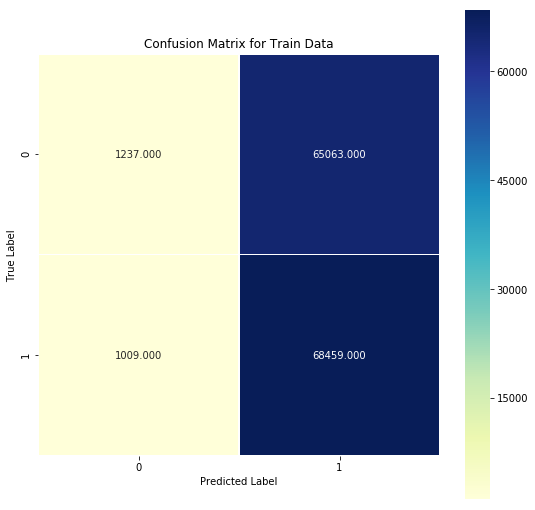

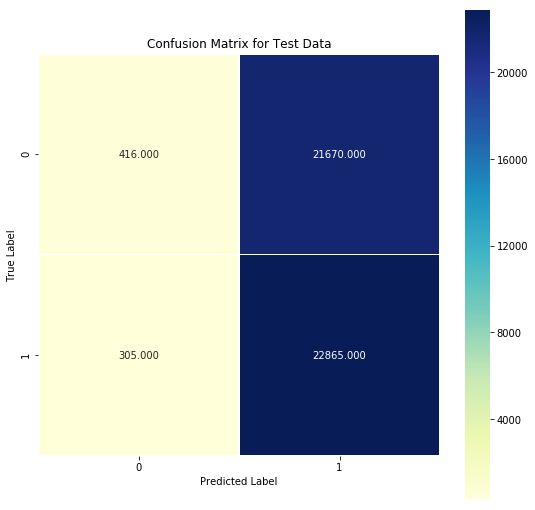

In [54]:
knn = model_maker(KNeighborsClassifier(n_jobs = 8))

## Logistic Regression Iteration 1
This model saw a 4% boost to the F1 Score for training and testing and a 6% increase for testing data. The false negatives and positives decreased by several thousand and this model looks to be the best one

Training Scores
Precision Score: 0.6199537875108541
Recall Score: 0.6051429392328689
Accuracy Score: 0.6073522479523894
F1 Score: 0.6124588352464797

Testing Scores
Precision Score: 0.6128789887739768
Recall Score: 0.602179954837589
Accuracy Score: 0.6040304048082022
F1 Score: 0.6074823673719719


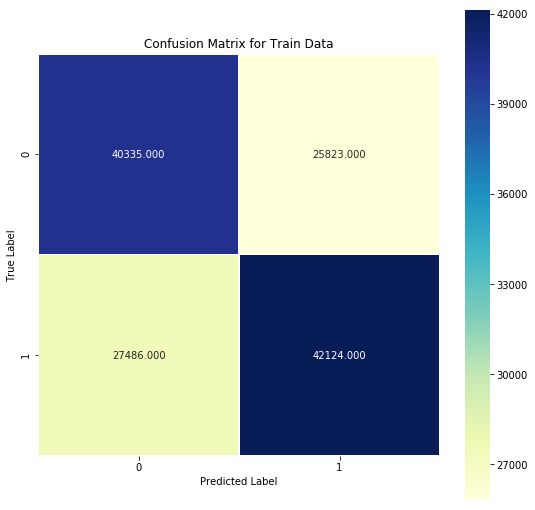

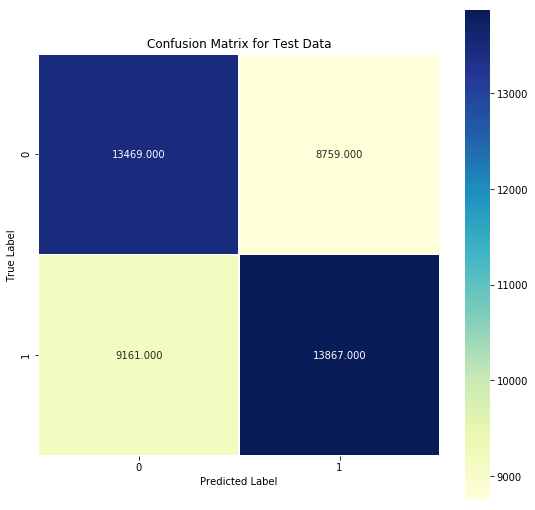

In [46]:
logreg = model_maker(LogisticRegression(n_jobs = 8))

In [47]:
pred = []
for predictions in logreg.predict_proba(df.drop('radiant_win', axis=1)):
    pred.append(predictions[1])
df['Probability'] = pred

In [48]:
df.to_csv('Dataframe_after_first_iteration.csv')

Training Scores
Precision Score: 0.5795056682849371
Recall Score: 0.6409466501597904
Accuracy Score: 0.5783321548523953
F1 Score: 0.6086796038196273

Testing Scores
Precision Score: 0.5828317400369802
Recall Score: 0.6393492145693078
Accuracy Score: 0.5810279299982323
F1 Score: 0.6097837048013007


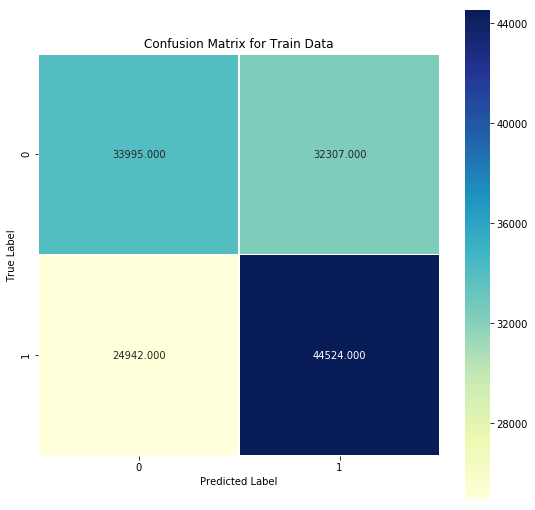

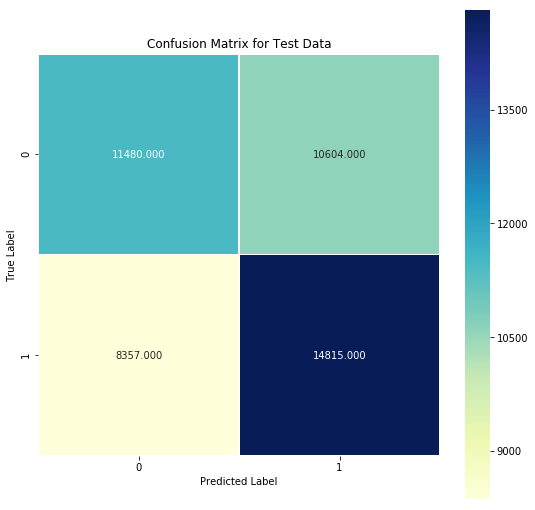

In [47]:
best_logreg = model_maker(LogisticRegression(solver='saga', C=.001, n_jobs=-1))

## Decision Trees Iteration 1
This model predicted more winners after the creation of dummy variables and is significantly better than the initial model. This model predicts true losses better than any other model so combining this with logistic and XGBoost might be the best combination

Training Scores
Precision Score: 0.6309521515425973
Recall Score: 0.47139278412853813
Accuracy Score: 0.588511283954982
F1 Score: 0.5396247249713642

Testing Scores
Precision Score: 0.6274974015475228
Recall Score: 0.468809318377912
Accuracy Score: 0.5853809439632314
F1 Score: 0.5366684774556768


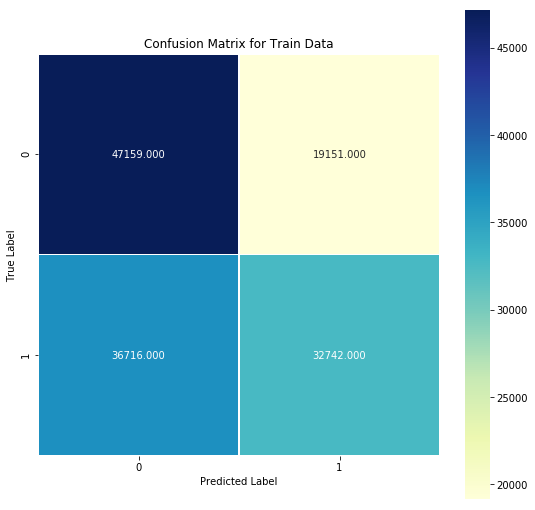

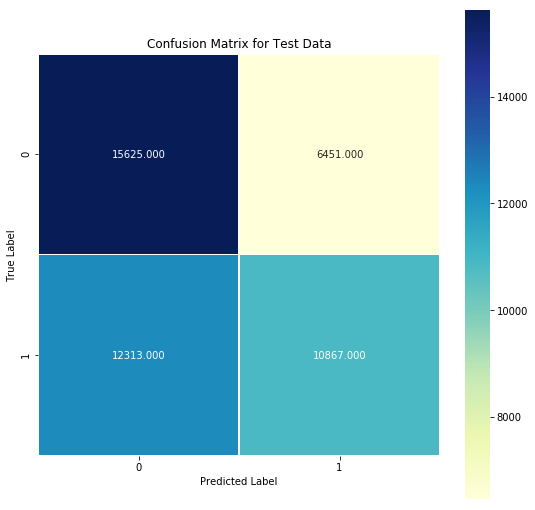

In [53]:
dt = model_maker(DecisionTreeClassifier())

## Random Forest Iteration 1
This model predicted more winners after the creation of dummy variables and is significantly better than the initial model. However, it is not the best model. 

Training Scores
Precision Score: 0.6370796205806266
Recall Score: 0.4780914307079481
Accuracy Score: 0.5931883801779506
F1 Score: 0.5462521770562914

Testing Scores
Precision Score: 0.6375344986200552
Recall Score: 0.48002078012035154
Accuracy Score: 0.5953022803606152
F1 Score: 0.547677261613692


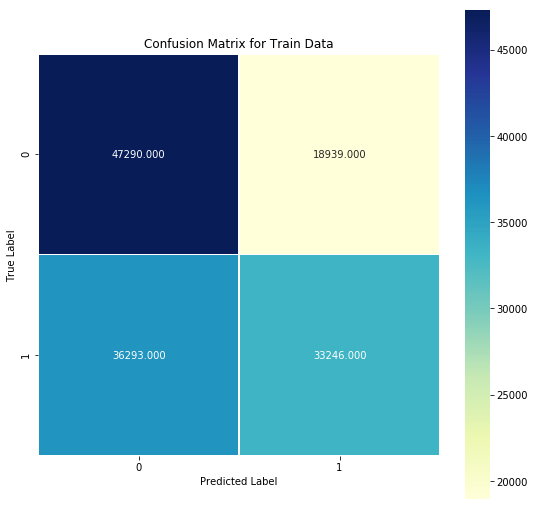

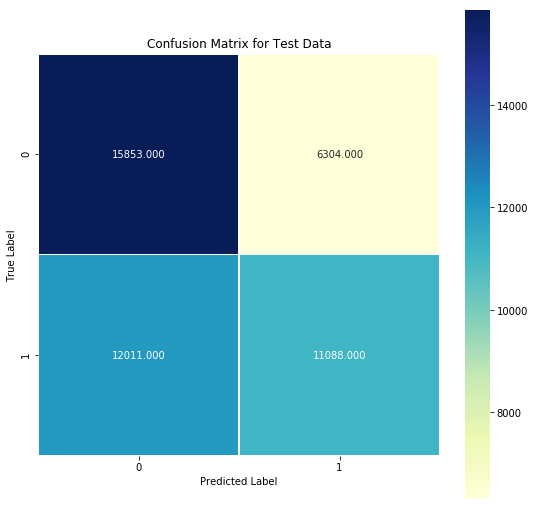

In [49]:
rf = model_maker(RandomForestClassifier(n_jobs = 6))

# XGBoost Iteration 1
Best model so far, however logistic regression predicts true losses better so combining this model and logistic regression might yield better results

In [50]:
xg_clf = XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 10, n_estimators = 100, n_jobs=8)

X = df.drop('radiant_win', axis=1)
y = df.radiant_win
    
X_train, X_test, y_train, y_test = train_test_split(X, y)
    
scaler = StandardScaler()
scaler.fit(X_train)
    
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [51]:
xg_clf.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Training Scores
Precision Score: 0.6625823541397813
Recall Score: 0.6997188271073621
Accuracy Score: 0.6628734311472512
F1 Score: 0.6806444185511048

Testing Scores
Precision Score: 0.6503476599032245
Recall Score: 0.6975141735717401
Accuracy Score: 0.6567305992575571
F1 Score: 0.6731056541043284


Text(0.5, 1.0, 'Confusion Matrix for Test Data')

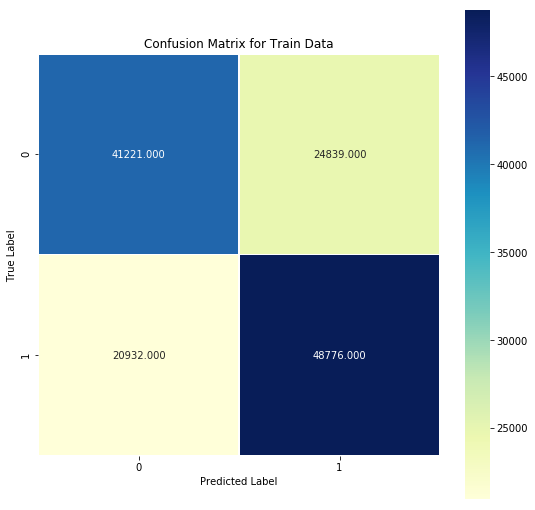

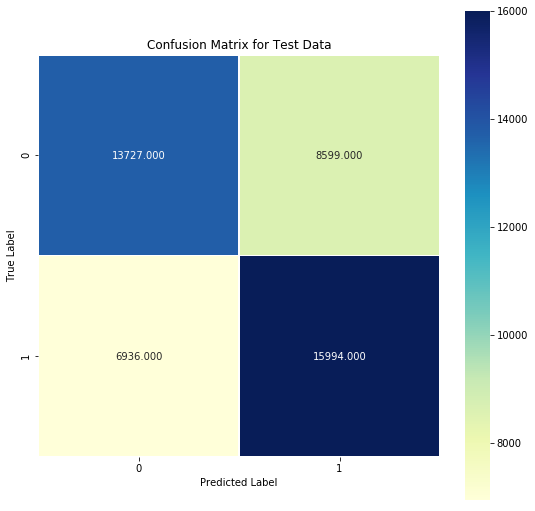

In [52]:
train_preds = xg_clf.predict(X_train)
test_preds = xg_clf.predict(X_test)

print("Training Scores")
print("Precision Score: {}".format(precision_score(y_train, train_preds)))
print("Recall Score: {}".format(recall_score(y_train, train_preds)))
print("Accuracy Score: {}".format(accuracy_score(y_train, train_preds)))
print("F1 Score: {}".format(f1_score(y_train, train_preds)))

cm_lr = confusion_matrix(y_train, train_preds)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Train Data')
    
print("\nTesting Scores")
print("Precision Score: {}".format(precision_score(y_test, test_preds)))
print("Recall Score: {}".format(recall_score(y_test, test_preds)))
print("Accuracy Score: {}".format(accuracy_score(y_test, test_preds)))
print("F1 Score: {}".format(f1_score(y_test, test_preds)))
    
    
cm_lr = confusion_matrix(y_test, test_preds)

plt.figure(figsize = (9, 9))
sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Test Data')

# Pickling My Models

In [58]:
#save our model
import pickle # pickle list object
model_pickle_path = 'Logistic_Regression.pkl'

model_pickle = open(model_pickle_path, 'wb')
pickle.dump(logreg, model_pickle)
model_pickle.close()

In [59]:
model_pickle_path2 = 'XGBoost.pkl'

model_pickle = open(model_pickle_path2, 'wb')
pickle.dump(xg_clf, model_pickle)
model_pickle.close()

In [60]:
model_pickle_path3 = 'Random_Forest.pkl'

model_pickle = open(model_pickle_path3, 'wb')
pickle.dump(rf, model_pickle)
model_pickle.close()